# Chargement des données
On upload notre dataset d'images au format jpg et correctemment nommées, et on le convertit en images et labels au format npy 


In [0]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import cv2

import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


In [0]:
!rm *.zip
from google.colab import files
files.upload()


rm: cannot remove '*.zip': No such file or directory


Saving image.zip to image.zip


{u'image.zip': 'PK\x03\x04\x14\x03\x00\x00\x00\x00p\x82\xa6N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00image/PK\x03\x04\x14\x03\x00\x00\x08\x00/\x96\xa3N\xe5oz\xb0\xab\t\x00\x00B\n\x00\x00 \x00\x00\x00image/1556902008.578178_1_-1.jpg\x9c\xcfIL\x13Q\x18\x07\xf0\xef\xcd{3o\xa6\x9dF^;`i\xa6\x96.X0\x84\xd8\xe9h\x8b\xd1\x18\x18\xa9\xc2\r\x14\xb7\x93\xe0\xeeIpAL<\x80\xbb\xf1\x82\xb8\x12c\xc4]o\x15q;\x89\xa2\xa8\xf1\x82+\xe2E\xdc\xf5\x80\x05w/\xe3\x94\xb8\\<(\xff\xef\xf8\xff\xe7K~f\xaf\xf9\x142\xca\x13e\t@\x08\x00Y\x07\xe6\x130@\x14\x04*\xf0"\xa5T\x92D\x9b\xac8d\xbb]\xcev\xbaF)^\x8fo\x8c\xd7\xa3\xaa9\xa1\xc2pN\xa0 \xa8\xaay\xb1\xfc\x82\xf1\x11]\xd7}\xe1\xa2)qmraT\xd7\xd2O\x90$I\xb2]v;\x1cn\xcd\xaf\xfa\xb5\xff\x8ey\x05\x98\x08\x0b\xe00F\x01\xe0\x18\xc2\x0c\x99]\xe0\x03@<\x1a\x0e\xfc\x0c\xe20\xe1\x05*J6\xbb5\xe8\xc8\x00\x0ea\xcc\x11\xcc\xf3\x84X\xed\x06\xab\x07\xc2x\xa7?R,\xb8*\xaai\xa0V\xd1\x1a\x9b\xdb\xc4`I\xb23\xb3\xb2\'\x15\x8a\xd6\xd45I\xb6\xac\xd1\xeelO\xee\xd8p^\xfe8

In [0]:
!unzip image.zip

In [0]:
dataset = "image"  #A remplacer par le nom du dossier contenant les images

In [0]:
def load_photos(directory):
    '''
    Loads the photo from the directory and return arrays of images and labels
    '''
    images = []
    directions = []
    vitesses = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        image = load_img(filename, target_size=(96, 160))
        image = img_to_array(image)
        images.append(image)
        direction = float((name.split('_')[2]).split('.jpg')[0])
        directions.append(direction)
        vitesse = float(name.split('_')[1])
        vitesses.append(vitesse)
    return images, directions, vitesses

In [0]:
X, Y, Z = load_photos(dataset)
print'Images chargées pour entraînement :',len(X)

Images chargées pour entraînement : 240


In [0]:
#Normalise images
X = np.array(X)
X /= 255.0

In [0]:
#convert datas to arrays 
Y = np.array(pd.get_dummies(Y)) #-1 -> [1,0,0] left ; 0 -> [0,1,0] straight ; 1 -> [0,0,1] right
Z = np.array(pd.get_dummies(Z))

In [0]:
!ls



# Augmentation des données

On augmente notre jeu de données à l'aide de fonction(s)

In [0]:
def mirror_image(X,Y):
    '''
    Do a horizontal flip on every images of the dataset
    '''
    X_mirror = []
    Y_mirror = []
    i=0
  
    for image in X:
        image = cv2.flip(image, 1)# 1 correspond to horizontal
        X_mirror.append(image)
        Y_mirror.append(np.flip(Y[i]))
        i=i+1
    return X_mirror,Y_mirror


In [0]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = 160 * np.random.rand(), 0
    x2, y2 = 160 * np.random.rand(), 96
    xm, ym = np.mgrid[0:96, 0:160]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    shadowed = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    return shadowed
  


In [0]:
def random_brightness(X,Y):
    X_bright = []
    Y_bright = []
    i=0
    
    for image in X:
        # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        ratio = 1 + 0.8 * (np.random.rand() - 0.5)
        hsv[:,:,2] =  hsv[:,:,2] * ratio
        tmp = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        X_bright.append(tmp)
        Y_bright.append(Y[i])
        i=i+1
    return X_bright, Y_bright


In [0]:
#Here we augment the data with the previously declared functions, you should adapt if you don't want to use all the augmentation functions
X_bright, Y_bright = random_brightness(X, Y)
X_tmp = np.concatenate((X, X_bright))
Y_tmp = np.concatenate((Y, Y_bright))


X_mirror, Y_mirror = mirror_image(X_tmp,Y_tmp)
X_final = np.concatenate((X_tmp, X_mirror))
Y_final = np.concatenate((Y_tmp, Y_mirror))
  


print'Le dataset est desormais composé de', len(Y_final),'images'

Le dataset est desormais composé de 960 images


# Visualisation des données
***Optionnel***

C'est ici qu'on peut visualiser notre dataset

(array([0, 0, 1, 0, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fef66bd1590>)

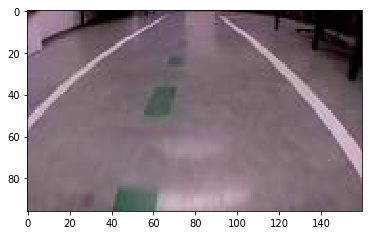

In [0]:
index_test = 150
Y_final[index_test], plt.imshow(X_final[index_test])

(array([0, 0, 1, 0, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7f03d219b490>)

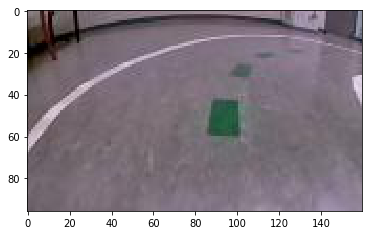

In [0]:
index_test_2 = 287
Y[index_test_2], plt.imshow(X[index_test_2])

In [0]:
def label_decoder(tab): #return the original label's value 
    if np.array_equal(tab, [1,0,0,0,0]):
        return -1
    elif np.array_equal(tab, [0,0,0,1,0]):
        return -0.5
    elif np.array_equal(tab, [0,0,1,0,0]):
        return 0
    elif np.array_equal(tab, [0,1,0,0,0]):
        return 0.5
    elif np.array_equal(tab, [0,0,0,0,1]):
        return 1
    else:
        print('Unknown label')
        return
      

Text(0.5,1,'Data distribution')

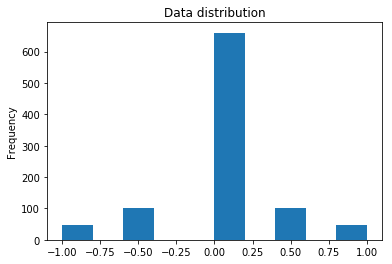

In [0]:
df = pd.DataFrame(Y_final)
df['direction'] = df.apply(label_decoder, axis=1)
df.direction.plot.hist()
plt.title('Data distribution')

# Entraînement du modèle
C'est dans cette section qu'on définie et entraîne le réseau de neuronnes avec notre jeu de données

In [0]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

## Choix de l'architecture du réseau de neuronnes
(ne lancer qu'un seul des 2 codes)

**Architecture du réseau n°1**

Apparemment moins performant mais entraînement plus rapide

In [0]:
K.clear_session()
############################################################# 

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(4, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Convolution2D(8, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)

x = Flatten(name='flattened')(x)

x = Dense(100, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Dense(50, use_bias=False)(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.3)(x)

# Multitask Output

#out_speed = Dense(2, activation='softmax')(x)

out_dir = Dense(5, activation='softmax')(x)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 96, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 78, 2)         150       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 78, 2)         8         
_________________________________________________________________
activation_1 (Activation)    (None, 46, 78, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 37, 4)         200       
_________________________________________________________________
batch_normalization_2

**Architecture du réseau n°2**

Apparemment plus performant mais l'entraînement est plus long

In [0]:
K.clear_session()

img_in = Input(shape=(96,160,3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
x = img_in
x = Conv2D(24, 5,5, subsample=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Conv2D(32, 5,5, subsample=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Conv2D(64, 5,5, subsample=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Conv2D(64, 3,3, subsample=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Conv2D(64, 3,3, subsample=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(0.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(0.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    
    #categorical output of the angle
angle_out = Dense(3, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
model = Model(input=[img_in], output=[angle_out])
    
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

## Entraînement et résultats


In [0]:
model_name="dir5.h5"

In [0]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [0]:
#Train model
try:
    h = model.fit(X_final, Y_final, batch_size=64, epochs=50, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])
except NameError:
    print'Augmented data have not been found, original data will be used' 
    h = model.fit(X, Y, batch_size=64, epochs=50, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 768 samples, validate on 192 samples
Epoch 1/50
768/768 [==============================] - 5s 7ms/step - loss: 1.6768 - acc: 0.2747 - val_loss: 1.2456 - val_acc: 0.5573

Epoch 00001: val_loss improved from inf to 1.24565, saving model to dir5.h5
Epoch 2/50
768/768 [==============================] - 4s 5ms/step - loss: 1.2409 - acc: 0.5078 - val_loss: 1.3832 - val_acc: 0.6302

Epoch 00002: val_loss did not improve from 1.24565
Epoch 3/50
768/768 [==============================] - 4s 5ms/step - loss: 0.9810 - acc: 0.6693 - val_loss: 1.1515 - val_acc: 0.7188

Epoch 00003: val_loss improved from 1.24565 to 1.15151, saving model to dir5.h5
Epoch 4/50
768/768 [==============================] - 4s 5ms/step - loss: 0.8200 - acc: 0.7448 - val_loss: 0.7479 - val_acc: 0.7031

Epoch 00004: val_loss improved from 1.15151 to 0.74785, saving model to dir5.h5
Epoch 5/50
768/768 [==============================] - 4s 5ms/step - loss: 0.7521 - acc:

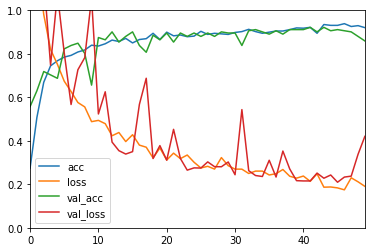

In [0]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [0]:
!ls

image  image.zip  polytest.h5  sample_data


In [0]:
from google.colab import files
files.download('dir5.h5')

# Validation du modèle
***Optionnel***

Ici on upload un nouveau jeu d'images avec labels et on vérifie le bon fonctionnement de notre modèle

In [0]:
# Chargement du model
model_name="dir5.h5"
model = load_model(model_name)


##Validation sur autre jeu de données (à télécharger)

In [0]:
from google.colab import files
files.upload()

Saving test.zip to test.zip


{u'test.zip': 'PK\x03\x04\n\x00\x00\x00\x00\x00\x81\x98\xa1N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00test/PK\x03\x04\x14\x00\x00\x00\x08\x00\x8f\xa2\x84N\xd2\xfc*\x9aY\r\x00\x00\xdf\r\x00\x00 \x00\x00\x00test/1_-1_1554409231.0635078.jpg\x9d\xd5y8\xd4Q\xdb\x07\xf0\xdf,\xf6\xb1\x85B#\xccH\x8bu\x06e+YFC\xb2\xef\xad\xf6-d\xc96\x96\x90%D3\x13\x95\xbd,#\x8c=LQa\xac\xd9\xb2\x87\xb2\x0f\xca\xda$;\x8f\x9e\xebY\xfey\xffx\xdf\xf7{\xfe\xbc\xef\xeb\\\xe7s\xdd\xe7:\xe7p\xe4p\x12\xe0\xd2\xd5\xd6\xd1\x06@ \x00\x00\x1d-\xe0p\x0c\xd0\x04\x98\x19\x19\x99\x18\x19\x98\x99\x98\x98XX\x98Ya\xbc\xec066\x98\xc01\x1eN^!A\xe1SB\x82p\xb8\x88\x98\xf4\x19\x11\x84$\x12\x0e?{\xf1\x9c\xa4,J^^^\xf8\x8c\xd2%E\xb4\xaa\xb4\x9c<\xfa\xef& \x16\x16\x16\x18\x1b\x8c\x9f\x9d\x9d\x1f-\n\x17E\xff\x9fs\xf8\t\xe0f\x06\xee\x02\xd9\x10\x10\x02\x00s\x83 \xdc\xa0C* |tN\x06\xd0?\x03\xfc+ 0\x04\xca\xc0\xc8\xc4\xcc\xc2\xcav\xd4\xf0\x96\x0b\x00\x83 \x100\x14\xc2\xc0\x00\x85\x1eUC\x8e\xea\x00\x94\x9b\xe1\x98(J\x9d\x91\

In [0]:
!unzip test.zip

In [0]:
validation = "test"

In [0]:
X_test, Y_test, Z_test = load_photos(validation)
nb_images2 = len(X_test)
print 'Images chargées pour validation :', nb_images2

Images chargées pour validation : 406


In [0]:
# Normalise les images de test
X_test = np.array(X_test)
X_test /= 255.0

In [0]:
# Obtenir les predictions pour chaque images
predictions = model.predict(X_test)

tab_preds = []
for elem in predictions:
    tab_preds.append(np.argmax(elem))

In [0]:
# Afficher le pourcentage de réussite
correct_pred = 0
droite = 0
gauche = 0
tout_droit = 0
for i, value in enumerate(tab_preds):
   #print(value, Y_test[i])       #Decommeneter cette ligne pour afficher le detail (donnée réelle vs prédiction)
   if(value==0 and Y_test[i] == -1):
        correct_pred += 1
   elif(value==1 and Y_test[i] == -0.5):
        correct_pred += 1
   elif(value==2 and Y_test[i] == 0):
        correct_pred += 1
   elif(value==3 and Y_test[i] == 0.5):
        correct_pred += 1
   elif(value==4 and Y_test[i] == 1):
        correct_pred += 1
   
reussite = float(correct_pred)*100./(float(i)+1.)
print correct_pred,'/',i+1,'correctement predits <=> ',reussite,'% de réussite'
  

(1, 0.0)
(1, 0.0)
(1, -1.0)
(1, -1.0)
(1, -1.0)
(1, 0.0)
(1, 0.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, -1.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, -1.0)
(1, -1.0)
(1, -1.0)
(1, 1.0)
(1, -1.0)
(1, 1.0)
(1, 1.0)
(1, -1.0)
(1, -1.0)
(1, -1.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 0.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(2, 1.0)
(1, 0.0)
(1, 0.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, -1.0)
(1, -1.0)
(1, 1.0)
(1, -1.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, 0.0)
(1, -1.0)
(1, -1.0)
(1, 1.0)
(1, 1.0)
(1, -1.0)
(1, -1.0)
(1, 0.0)
(1, 0.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, -1.0)
(1, 1.0)
(1, -1.0)
(1, -1.0)
(1, 0.0)
(1, 1.0)
(1, -1.0)
(1, -1.0)
(1, 0.0)
(1, -1.0)
(1, -1.0)
(1, -1.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, -1.0)
(1, -1.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 1.0)
(1, 1.0)
(1, 0.0)
(1, 0.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)
(1, 1.0)
(1, 0.0)


##Validation sur le jeu de données de départ

In [0]:
X_test, Y_test, Z_test = load_photos(dataset)
print'Images chargées pour validation :',len(X_test)

Images chargées pour validation : 240


In [0]:
# Normalise les images de test
X_test = np.array(X_test)
X_test /= 255.0

In [0]:
# Obtenir les predictions pour chaque images
predictions = model.predict(X_test)

tab_preds = []
for elem in predictions:
    tab_preds.append(np.argmax(elem))

In [0]:
# Afficher le pourcentage de réussite
correct_pred = 0
droite = 0
gauche = 0
tout_droit = 0
for i, value in enumerate(tab_preds):
   #print(value, Y_test[i])       #Decommeneter cette ligne pour afficher le detail (donnée réelle vs prédiction)
   if(value==0 and Y_test[i] == -1):
        correct_pred += 1
   elif(value==1 and Y_test[i] == -0.5):
        correct_pred += 1
   elif(value==2 and Y_test[i] == 0):
        correct_pred += 1
   elif(value==3 and Y_test[i] == 0.5):
        correct_pred += 1
   elif(value==4 and Y_test[i] == 1):
        correct_pred += 1
   
reussite = float(correct_pred)*100./(float(i)+1.)
print correct_pred,'/',i+1,'correctement predits <=> ',reussite,'% de réussite'
  

234 / 240 correctement predits <=>  97.5 % de réussite
